<a href="https://colab.research.google.com/github/thesea58/transformer/blob/main/TF_hop_am.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
javascript:void(setInterval(function(){ console.log("Connect pushed"); document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click(); },60000))

In [ ]:
!nvidia-smi

Mon Apr 17 13:00:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# cài dặt và import thư viện

In [15]:
import os
import math
import time
import json
import music21 as m21
import numpy as np
import pandas as pd
import glob
import pickle
from tqdm import tqdm
import tensorflow as tf
# from tensorflow.keras.utils import pad_sequences
from typing import Collection, List

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content/drive/MyDrive/Colab Notebooks/AI nhac viet/code/
import convert 
import convert_goc
import vocab 
import numpy_encode 
import transformer_tf as transf_tf
import transformer
from  transformer import TransformerDecoder, TransformerMusicGenerator, MusicGenerator,ExportMusicGenerator
from  transformer import *
import tokenizer_dataset 
# import playmidi 

%cd ..

/content/drive/MyDrive/Colab Notebooks/AI nhac viet/code
/content/drive/MyDrive/Colab Notebooks/AI nhac viet


# dataset

In [6]:
max_len = 512
transpose = 4
batch_size = 40
created_vocab = convert_goc.MusicVocab.create()
print(f'vocabulary size: {len(created_vocab)}')
fp = './data_midi_hopam/midi_songs/'

# train_ds = convert_goc.create_dataset('./data_midi_hopam/midi_songs/MEGA/', created_vocab, max_len, batch_size, transpose)
val_ds = convert_goc.create_dataset('./data_midi_hopam/midi_songs_val/', created_vocab, max_len, batch_size, transpose, shuffle=False)

# Load the dataset from the file
train_ds = tf.data.Dataset.load(f"./dataset_MEGA_512_{batch_size}")

# Prefetch the data to optimize performance
train_ds = train_ds.prefetch(batch_size)
print(f"có {len(train_ds)} batch")

vocabulary size: 298
tìm thấy 1 file 
0đã load lại: /content/drive/MyDrive/Colab Notebooks/AI nhac viet/data_midi_hopam/midi_songs_val/balamb.mid.txt
có 3698 batch


In [ ]:
# q =2
# for i,o in train_ds.take(3):
#   pass
# print(i) 
# print(o) 

In [ ]:
# generated1 = convert_goc.idxenc2stream(i[2].numpy(), vocab=created_vocab)
# generated1.show('midi')
# generated2 = convert_goc.idxenc2stream(o[2].numpy(), vocab=created_vocab)
# generated2.show('midi')

In [ ]:
# tf.data.Dataset.save(train_ds, f"./dataset_MEGA_512_{batch_size}")

# build model và load checkpoint

In [18]:

num_layers = 6
d_model =   256
dff = 512
num_heads = 8
dropout_rate = 0.4
transformer_model = TransformerDecoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=len(created_vocab),
        pe_target=max_len,
        rate=dropout_rate)

# transformer_model = tf.saved_model.load('./code/save_model/decoder_only_smaller_1024_mega_ds_gh')

learning_rate = transformer.CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='validation_loss')
val_accuracy = tf.keras.metrics.Mean(name='validation_accuracy')

checkpoint_path = "./code/training_checkpoints/ckpt_MEGA_512/"

ckpt = tf.train.Checkpoint(transformer=transformer_model,
                            optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

gen_tokens = convert_goc.midi2idxenc('./data_midi_hopam/midi_songs/MEGA/Melody Of The Night 21.mid', created_vocab, add_bos=True, add_eos=True)[:128]
prev_train_loss = math.inf
prev_val_loss = math.inf
tf_generator = transformer.TransformerMusicGenerator(transformer_model, max_len)
exporter = transformer.ExportMusicGenerator(tf_generator)


train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        predictions, _ = transformer_model(inp, training=True)
        loss = transformer.loss_function(tar, predictions)

    gradients = tape.gradient(loss, transformer_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer_model.trainable_variables))

    train_loss(loss)
    train_accuracy(transformer.accuracy_function(tar, predictions))

None: converted ./data_midi_hopam/midi_songs/MEGA/Melody Of The Night 21.mid to index encoding (1517 tokens)


/content/drive/MyDrive/Colab Notebooks/AI nhac viet/code/numpy_encode.py:103: StreamIteratorInefficientWarning: highestTime is not defined on StreamIterators. Call .stream() first for efficiency
  highest_time = max(s.flat.getElementsByClass('Note').highestTime, s.flat.getElementsByClass('Chord').highestTime)


In [19]:
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
    # tf_gen = TransformerMusicGenerator(transformer_model, max_len)
    # exporter = ExportMusicGenerator(tf_gen)
    # tokens_original = convert_goc.midi2idxenc('./data_midi_hopam/midi_songs/FF4.mid', created_vocab, add_bos=False, add_eos=False)[:256]
    # generator = MusicGenerator(exporter)
    # generator.save(fp='./code/save_model/decoder_only_smaller_1024_mega_ds')

    # gen_len = 128
    # generated = generator.extend_sequence(input_sequence=tokens_original, max_generate_len=gen_len)
    # print(generated[-(gen_len + 2):])
    # generated1 = convert_goc.idxenc2stream(tokens_original, vocab=created_vocab)
    # generated1.show('midi')
    # generated2 = convert_goc.idxenc2stream(generated.numpy(), vocab=created_vocab)
    # generated2.show('midi')
    # generated.write('midi', fp='../generated/generated_greed.mid')


Latest checkpoint restored!!


In [26]:
# for (batch, (val_inp, val_tar)) in enumerate(train_ds):    
#     break
# val_logits, _ = transformer_model(val_inp, training=False)
# print(val_accuracy(transformer.accuracy_function(val_tar, val_logits)))

#Train

## plot acc loss

In [21]:
#@title def plot loss acc
import matplotlib.pyplot as plt
def plot_loss_acc(df):
    # Vẽ b  iểu đồ epoch vs. loss
    plt.plot(df['Epoch'], df['Loss'], label='Training Loss')
    plt.plot(df['Epoch'], df['Loss val'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ epoch vs. accuracy
    plt.plot(df['Epoch'], df['Accuracy'], label='Training Accuracy')
    plt.plot(df['Epoch'], df['Accuracy val'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ loss vs. accuracy
    plt.plot(df['Loss'], df['Accuracy'], label='Training')
    plt.plot(df['Loss val'], df['Accuracy val'], label='Validation')
    plt.xlabel('Loss')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ epoch vs. loss và accuracy
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(df['Epoch'], df['Loss'], color=color, label='Training Loss')
    ax1.plot(df['Epoch'], df['Loss val'], color=color, linestyle='dashed', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # Tạo trục thứ hai
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy')
    ax2.plot(df['Epoch'], df['Accuracy'], color=color, label='Training Accuracy')
    ax2.plot(df['Epoch'], df['Accuracy val'], color=color, linestyle='dashed', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.show()

load history!
   Epoch  Loss val  Accuracy val      Loss  Accuracy
0    1.0  2.399733      0.300010  2.693282  0.307693
1    2.0  2.369291      0.368875  2.508445  0.325312
2    3.0  2.365431      0.405601  2.496244  0.326011
3    4.0  2.368650      0.423485  2.488963  0.326527
4    5.0  2.371956      0.438310  2.483587  0.326966
5    6.0  2.373129      0.445788  2.478963  0.327479
6    7.0  2.377382      0.453663  2.474616  0.328097
7    8.0  2.382885      0.460289  2.470760  0.328620
8    9.0  2.386724      0.465647  2.467016  0.329207
9   10.0  2.389853      0.469203  2.463360  0.329778


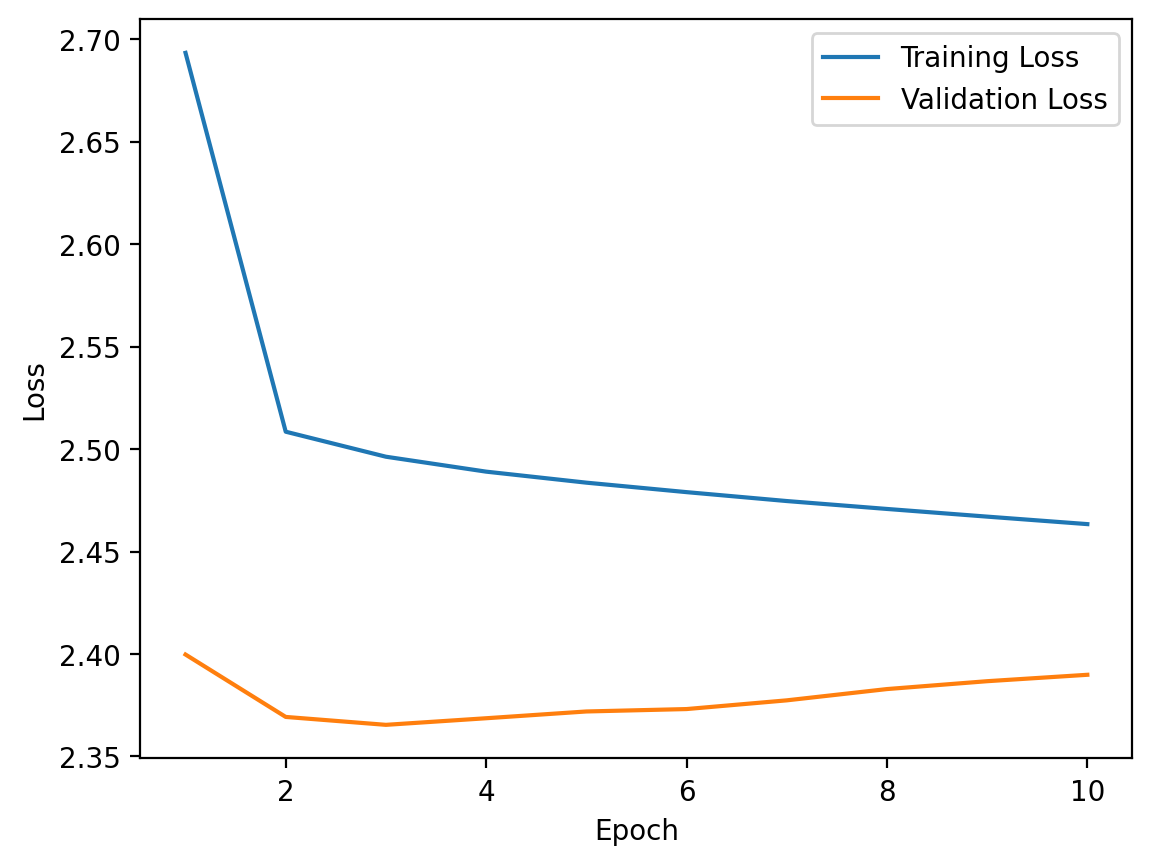

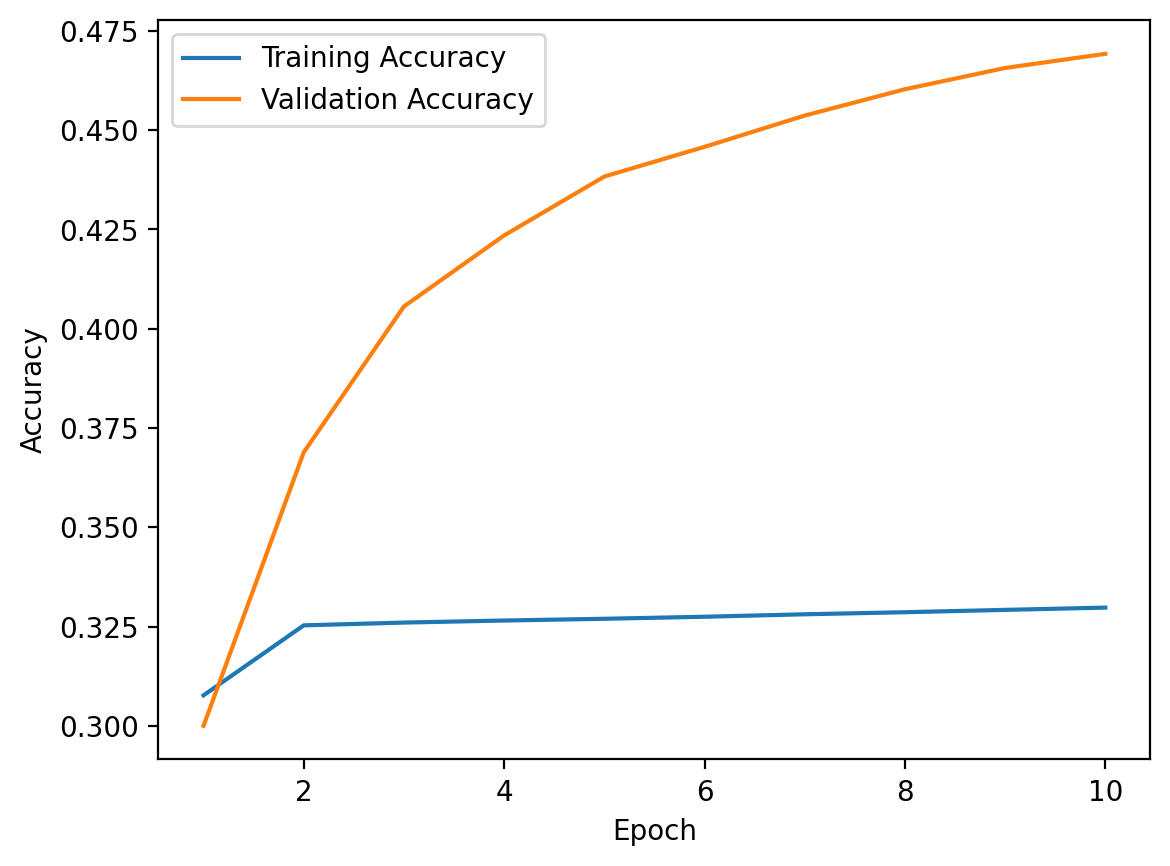

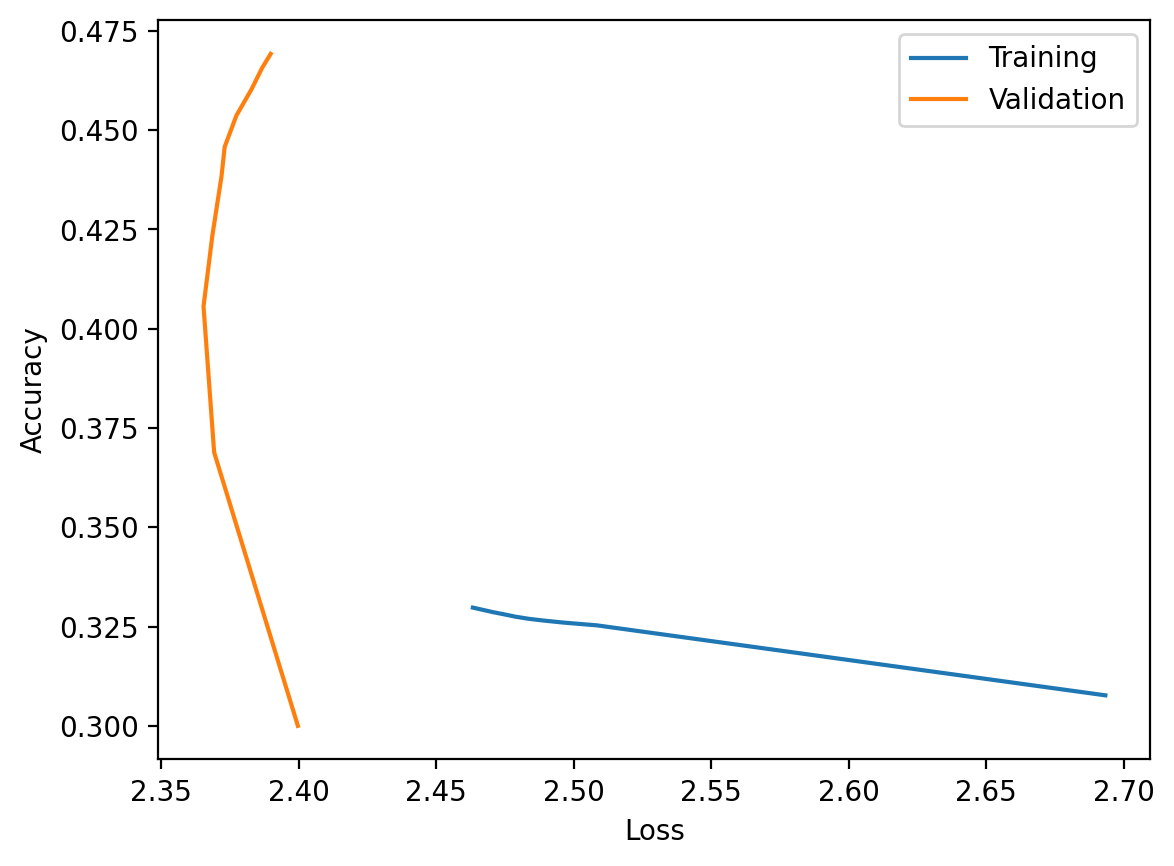

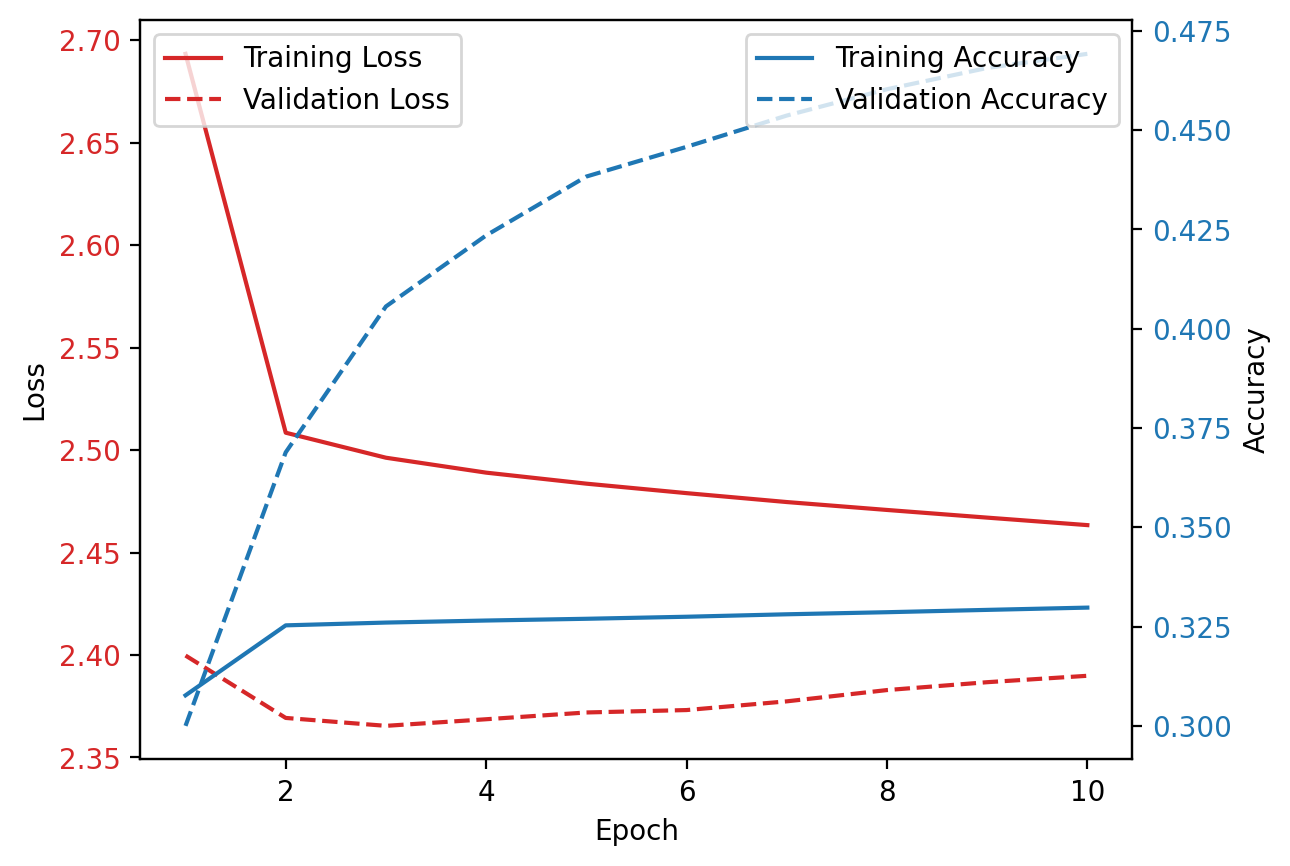

In [25]:
import re
history_path = './history_MEGA_512_df.csv'
print('load history!')
history = pd.read_csv(history_path, index_col=False)
# plot_loss_acc(history)
def chuyen_history_loi(df):
    # Kiểm tra kết quả
    df = history

    # Trích xuất giá trị số từ cột Epoch
    df['Epoch'] = df['Epoch'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

    # Trích xuất giá trị số từ các cột còn lại
    regex = r'(\d+(\.\d+)?)'
    for col in df.columns[1:]:
        df[col] = df[col].apply(lambda x: float(re.findall(regex, x)[0][0]))
    return df

# Kiểm tra kết quả
# history = chuyen_history_loi(history)
print(history)
plot_loss_acc(history)
# history.to_csv(history_path, index=False)


In [ ]:

# làm rỗng history
# col = {'Epoch': [],
#         'Loss val': [],
#         'Accuracy val': [],
#         'Loss': [],
#         'Accuracy': []}
# history_path = './history_MEGA_512_df.csv'
# history = pd.DataFrame(col)
# history.to_csv(history_path, index=False)

## Train

In [ ]:

import warnings
warnings.filterwarnings('ignore', message='The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.')


col = {'Epoch': [],
        'Loss val': [],
        'Accuracy val': [],
        'Loss': [],
        'Accuracy': []}
history_path = './history_MEGA_512_df.csv'


if os.path.isfile(history_path):
    print('load history!')
    history = pd.read_csv(history_path, index_col=False)
else:
    print('tạo df history!')
    history = pd.DataFrame(col)


EPOCHS = 2
if len(history['Epoch'])>0:
  max_epoch = history['Epoch'].max()
else:
  max_epoch = 0
print(f"băt đầu lại từ epoch{max_epoch+1}")
for epoch in range((int(max_epoch)),int(max_epoch+EPOCHS),1):
        start = time.time()
        train_loss.reset_states()
        train_accuracy.reset_states()

        # inp -> seq, tar -> seq(shifted +1)
        for (batch, (train_inp, train_tar)) in tqdm(enumerate(train_ds), total = len(train_ds)):
            
            train_start = time.time()
            train_step(train_inp, train_tar)
            train_time = time.time() - train_start
            # if batch % 5 == 0:
            train_loss_batch = train_loss.result()
            train_accuracy_batch = train_accuracy.result()
            if batch %400 ==0 :
                print(
                    f'Epoch {epoch + 1} Batch {batch} Loss {train_loss_batch:.4f} Accuracy {train_accuracy_batch:.4f}')
            # description = f"Epoch {epoch + 1} | Loss: {train_loss_batch:.4f} | Acc: {train_accuracy_batch:.4f}"
            # tqdm.write(description)

            # tqdm.set_description(description, refresh=True)

        # Run a validation loop at the end of each epoch.
        for (batch, (val_inp, val_tar)) in enumerate(val_ds):
            val_logits, _ = transformer_model(val_inp, training=False)
            # Update val metrics
            val_loss_calc = transformer.loss_function(val_tar, val_logits)
            val_loss(val_loss_calc)
            val_accuracy(transformer.accuracy_function(val_tar, val_logits))
        val_acc_res = val_accuracy.result()
        val_loss_res = val_loss.result()

        train_loss_epoch = train_loss.result()
        train_accuracy_epoch = train_accuracy.result()
        print(f'Epoch {epoch + 1}: Loss {train_loss_epoch:.4f}, Valiation loss {val_loss_res:.4f}, Accuracy {train_accuracy_epoch:.4f}, Valiation accuracy {val_acc_res:.4f}')
        step = {'Epoch': int(epoch) + 1,
                'Loss val': val_loss_res.numpy(),
                'Accuracy val': val_acc_res.numpy(),
                'Loss': train_loss_epoch.numpy(),
                'Accuracy': train_accuracy_epoch.numpy()}

        history = history.append(step, ignore_index=True)
        history.to_csv(history_path, index=False)
        print("đã lưu lại history !")

        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs')
        if train_loss_epoch < prev_train_loss or val_loss_res < prev_val_loss:
            print(f'#####################{prev_train_loss:.4f} -> {train_loss_epoch:.4f}')
            prev_train_loss = train_loss_epoch
            prev_val_loss = val_loss_res
            gen_time_start = time.time()
            gen = tf_generator.iterative_search(tf.convert_to_tensor(gen_tokens), 32, True, 0, 0, 0, 1.0)[0]
            gen_time = time.time() - gen_time_start
            # Print the 4 last tokens in the generation input as well to check if the output makes sense
            print(f'generated({gen_time:.4f}):\n{gen[-36:]}\n')
            stream = convert_goc.idxenc2stream(gen.numpy(), created_vocab)
            stream.show('midi')
            stream.write('midi', fp='./generated_greed.mid')
            # if train_accuracy_epoch > 0.6:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

load history!
băt đầu lại từ epoch9.0


  0%|          | 1/3698 [00:00<36:12,  1.70it/s]

Epoch 9 Batch 0 Loss 2.0683 Accuracy 0.5138


 11%|█         | 401/3698 [03:09<30:05,  1.83it/s]

Epoch 9 Batch 400 Loss 2.6338 Accuracy 0.2861


 22%|██▏       | 801/3698 [06:18<26:17,  1.84it/s]

Epoch 9 Batch 800 Loss 2.6391 Accuracy 0.2845


 32%|███▏      | 1201/3698 [09:27<22:53,  1.82it/s]

Epoch 9 Batch 1200 Loss 2.6343 Accuracy 0.2823


 43%|████▎     | 1601/3698 [12:36<19:21,  1.81it/s]

Epoch 9 Batch 1600 Loss 2.6304 Accuracy 0.2822


 54%|█████▍    | 2001/3698 [15:44<15:34,  1.82it/s]

Epoch 9 Batch 2000 Loss 2.5936 Accuracy 0.2941


 65%|██████▍   | 2401/3698 [18:53<11:52,  1.82it/s]

Epoch 9 Batch 2400 Loss 2.5649 Accuracy 0.3007


 76%|███████▌  | 2801/3698 [22:02<08:12,  1.82it/s]

Epoch 9 Batch 2800 Loss 2.5432 Accuracy 0.3085


 87%|████████▋ | 3201/3698 [25:11<04:33,  1.82it/s]

Epoch 9 Batch 3200 Loss 2.5182 Accuracy 0.3166


 97%|█████████▋| 3601/3698 [28:20<00:53,  1.82it/s]

Epoch 9 Batch 3600 Loss 2.4765 Accuracy 0.3271


100%|██████████| 3698/3698 [29:05<00:00,  2.12it/s]


Epoch 9: Loss 2.4670, Valiation loss 2.3867, Accuracy 0.3292, Valiation accuracy 0.4656
đã lưu lại history !
Time taken for 1 epoch: 1746.43 secs
#####################2.4708 -> 2.4670
generated(3.1105):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 9 at ./code/training_checkpoints/ckpt_MEGA_512/ckpt-9


  0%|          | 1/3698 [00:00<38:16,  1.61it/s]

Epoch 10 Batch 0 Loss 2.0459 Accuracy 0.5148


 11%|█         | 401/3698 [03:09<30:17,  1.81it/s]

Epoch 10 Batch 400 Loss 2.6308 Accuracy 0.2866


 22%|██▏       | 801/3698 [06:18<26:37,  1.81it/s]

Epoch 10 Batch 800 Loss 2.6363 Accuracy 0.2850


 32%|███▏      | 1201/3698 [09:26<22:49,  1.82it/s]

Epoch 10 Batch 1200 Loss 2.6316 Accuracy 0.2827


 43%|████▎     | 1601/3698 [12:35<19:14,  1.82it/s]

Epoch 10 Batch 1600 Loss 2.6277 Accuracy 0.2826


 54%|█████▍    | 2001/3698 [15:44<15:37,  1.81it/s]

Epoch 10 Batch 2000 Loss 2.5906 Accuracy 0.2946


 65%|██████▍   | 2401/3698 [18:53<11:55,  1.81it/s]

Epoch 10 Batch 2400 Loss 2.5617 Accuracy 0.3013


 76%|███████▌  | 2801/3698 [22:02<08:14,  1.82it/s]

Epoch 10 Batch 2800 Loss 2.5400 Accuracy 0.3090


 87%|████████▋ | 3201/3698 [25:11<04:34,  1.81it/s]

Epoch 10 Batch 3200 Loss 2.5147 Accuracy 0.3171


 97%|█████████▋| 3601/3698 [28:20<00:53,  1.83it/s]

Epoch 10 Batch 3600 Loss 2.4729 Accuracy 0.3276


100%|██████████| 3698/3698 [29:05<00:00,  2.12it/s]


Epoch 10: Loss 2.4634, Valiation loss 2.3899, Accuracy 0.3298, Valiation accuracy 0.4692
đã lưu lại history !
Time taken for 1 epoch: 1762.36 secs
#####################2.4670 -> 2.4634
generated(3.3162):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 10 at ./code/training_checkpoints/ckpt_MEGA_512/ckpt-10


In [ ]:

# def load_model(fp):
#     return tf.saved_model.load(fp)


# def get_song_tokens(vocab):
#     return midi2idxenc('../midi_songs/ff4pclov.mid', vocab, add_bos=True, add_eos=False)


# def get_middle_c_song(vocab):
#     return [vocab.stoi['n100'], vocab.stoi['d10'], vocab.stoi['n109'], vocab.stoi['d10'], vocab.stoi['n112'],
#             vocab.stoi['d10']]


# loaded_model = tf.saved_model.load('./')
# generator = MusicGenerator(loaded_model)
# created_vocab = MusicVocab.create()

# # tokens_original = midi2idxenc('../midi_songs/costadsol.mid', created_vocab, add_bos=False, add_eos=False)
# # tokens_original = get_middle_c_song(created_vocab)

# gen_len = 1024
# generated = generator.extend_sequence(input_sequence=None, max_generate_len=gen_len)
# print(generated[-(gen_len + 2):])

# generated = idxenc2stream(generated.numpy(), vocab=created_vocab)
# sp = music21.midi.realtime.StreamPlayer(generated)
# sp.play()
